In [1]:
import graphlab

In [2]:
graphlab.canvas.set_target('ipynb')

In [4]:
taps = graphlab.SFrame.read_csv("taps.csv", verbose=False)

In [5]:
taps.show()

In [6]:
features = [
    "n_accel",
    
    "accel_x_mean",
    "accel_x_median",
    "accel_x_var",
    "accel_x_skewness",
    "accel_x_kurtosis",
    "accel_x_diff",
    
    "accel_y_mean",
    "accel_y_median",
    "accel_y_skewness",
    "accel_y_kurtosis",
    "accel_y_var",
    "accel_y_diff",
    
    "accel_z_mean",
    "accel_z_var",   
    "accel_z_median",
    "accel_z_skewness",
    "accel_z_kurtosis",
    "accel_z_diff",
    
    "n_gyro",
    
    "gyro_x_mean",
    "gyro_x_median",
    "gyro_x_var",
    "gyro_x_skewness",
    "gyro_x_kurtosis",
    "gyro_x_diff",
    
    "gyro_y_mean",
    "gyro_y_median",
    "gyro_y_var",
    "gyro_y_skewness",
    "gyro_y_kurtosis",
    "gyro_y_diff",
    
    "gyro_z_mean",
    "gyro_z_median",
    "gyro_z_var",
    "gyro_z_skewness",
    "gyro_z_kurtosis",
    "gyro_z_diff",
    
] 



In [7]:
train, test = taps.random_split(0.8, seed=1)


145179
116149
29030


In [8]:
not_noise_train = train[train['noise'] == 0]
not_noise_test = test[test['noise'] == 0]

noise_train = train[train['noise'] == 1]
noise_test = test[test['noise'] == 1]

In [9]:
train_touchs = not_noise_train[not_noise_train['type'] == "TOUCH"]
train_swipes = not_noise_train[not_noise_train['type'] == "SWIPE"]
test_touchs = not_noise_test[not_noise_test['type'] == "TOUCH"]
test_swipes = not_noise_test[not_noise_test['type'] == "SWIPE"]

# Let's focus on boosted trees.

In [10]:
k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train), 5)

In [11]:
def f1_score(model, data):
    return model.evaluate(data, metric='f1_score')['f1_score']

def get_cross_val_score(k_fold, model_factory, model_params, metric_f):
    val_errors = []
    train_errors = []
    for train, valid in k_fold:
        m = model_factory(train, **model_params)
        val_errors.append(metric_f(m, valid))
        train_errors.append(metric_f(m, train))
    return sum(train_errors)/float(len(train_errors)), sum(val_errors)/float(len(val_errors))


def get_best_max_iterations(k_fold, max_iterations_a, model_factory, model_params, metric_f, plot=True):
    val_a = []
    train_a = []
    for max_iterations in max_iterations_a:
        model_params['max_iterations'] = max_iterations
        train_e, val_e = get_cross_val_score(k_fold, model_factory, model_params, metric_f)
        val_a.append(val_e)
        train_a.append(train_e)
        print "At iterations:", max_iterations, val_e, train_e
    if plot:
        %matplotlib inline

        import matplotlib
        import numpy as np
        import matplotlib.pyplot as plt

        plt.plot(max_iterations_a, val_a)
        plt.plot(max_iterations_a, train_a)
    if metric_f == f1_score:
        return max_iterations_a[val_a.index(max(val_a))], max(val_a)
    return max_iterations_a[val_a.index(min(val_a))], min(val_a)

def get_best_depth(k_fold, depths, model_factory, model_params, metric_f, plot=True):
    val_a = []
    train_a = []
    for depth in depths:
        model_params['max_depth'] = depth
        train_e, val_e = get_cross_val_score(k_fold, model_factory, model_params, metric_f)
        val_a.append(val_e)
        train_a.append(train_e)
        print "At depth:", depth, val_e, train_e
    if plot:
        %matplotlib inline

        import matplotlib
        import numpy as np
        import matplotlib.pyplot as plt

        plt.plot(depths, val_a)
        plt.plot(depths, train_a)
    if metric_f == f1_score:
        return depths[val_a.index(max(val_a))], max(val_a)
    return depths[val_errors.index(min(val_a))], min(val_a)

At iterations: 5 0.746662819823 0.746720971242
At iterations: 10 0.756014610524 0.756421794067
At iterations: 20 0.770686088064 0.77169138342
At iterations: 40 0.784572508002 0.7857007892
At iterations: 80 0.796250317791 0.797347490186
At iterations: 160 0.807478956556 0.809126134322
At iterations: 320 0.816087941649 0.818152045418
At iterations: 640 0.822583597949 0.825250273335


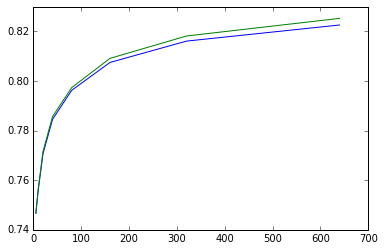

In [12]:
max_iterations_a = [5, 10, 20, 40, 80, 160, 320, 640]
model_params = dict([('target', 'noise'), ('features', features), ('verbose', False), ('validation_set', None),
                    ('max_depth', 1)])
model_factory = graphlab.boosted_trees_classifier.create
noise_max_iterations = get_best_max_iterations(k_fold, max_iterations_a, model_factory, model_params, f1_score)

At depth: 1 0.822583597949 0.825250273335
At depth: 2 0.878552887475 0.888164081954
At depth: 3 0.91815367583 0.938142868635
At depth: 4 0.949813896723 0.976847099082
At depth: 5 0.969059965903 0.995303732305
At depth: 6 0.976305008482 0.999675618944
At depth: 7 0.978880560502 1.0
At depth: 8 0.980475138397 1.0
At depth: 9 0.981141377204 1.0


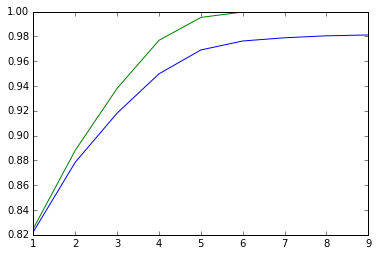

In [13]:
depths = range(1,10)
model_params['max_iterations'] = noise_max_iterations[0]
noise_max_depth = get_best_depth(k_fold, depths, model_factory, model_params, f1_score)

In [14]:
train_set_to_use = train
max_depth_to_use = noise_max_depth[0]
max_iterations_to_use = noise_max_iterations[0]

optimized_noise_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='noise', 
                                                                      features=features,
                                                                      max_depth=max_depth_to_use, 
                                                                      max_iterations=max_iterations_to_use)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 110232

Number of classes           : 2

Number of feature columns   : 38

Number of unpacked features : 38

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.316472     | 0.823363          | 0.805983            | 0.560188          | 0.565534            |

| 2         | 0.619618     | 0.847975          | 0.833700            | 0.482117          | 0.491638            |

| 3         | 0.985491     | 0.859460          | 0.844009            | 0.427139          | 0.439715            |

| 4         | 1.283949     | 0.872487          | 0.855163            | 0.385804          | 0.401056            |

| 5         | 1.593003     | 0.876678          | 0.860233            | 0.357077          | 0.373494            |

| 6         | 1.888696     | 0.885188          | 0.865810            | 0.330132          | 0.348888            |

| 10        | 3.019507     | 0.903504          | 0.885246            | 0.268305          | 0.291386            |

| 11        | 3.328393     | 0.907087          | 0.889978            | 0.257938          | 0.282164            |

| 15        | 4.431031     | 0.916131          | 0.895048            | 0.233218          | 0.259531            |

| 20        | 5.798069     | 0.936797          | 0.917019            | 0.194071          | 0.225342            |

| 25        | 7.078992     | 0.947402          | 0.925638            | 0.171855          | 0.207382            |

| 30        | 8.277848     | 0.952954          | 0.930201            | 0.158794          | 0.195482            |

| 35        | 9.523086     | 0.961173          | 0.933919            | 0.143058          | 0.181707            |

| 40        | 10.772631    | 0.966942          | 0.941186            | 0.130255          | 0.170611            |

| 45        | 12.054890    | 0.972386          | 0.946088            | 0.119624          | 0.162328            |

| 50        | 13.288528    | 0.976695          | 0.948116            | 0.109910          | 0.154249            |

| 51        | 13.531111    | 0.977384          | 0.950144            | 0.107618          | 0.152167            |

| 55        | 14.615210    | 0.981983          | 0.955721            | 0.094705          | 0.140236            |

| 60        | 15.896013    | 0.984215          | 0.956904            | 0.087703          | 0.134520            |

| 65        | 17.069741    | 0.985022          | 0.959777            | 0.084689          | 0.131836            |

| 70        | 18.291603    | 0.987100          | 0.959439            | 0.077598          | 0.124920            |

| 75        | 19.570621    | 0.988951          | 0.961805            | 0.071980          | 0.119448            |

| 80        | 20.859836    | 0.991046          | 0.963495            | 0.065906          | 0.114138            |

| 85        | 22.074202    | 0.992153          | 0.964171            | 0.062079          | 0.110692            |

| 90        | 23.403595    | 0.993133          | 0.965861            | 0.058282          | 0.107530            |

| 95        | 24.650818    | 0.994221          | 0.966875            | 0.054473          | 0.103645            |

| 100       | 25.945813    | 0.995038          | 0.968903            | 0.050466          | 0.100079            |

| 101       | 26.176264    | 0.995083          | 0.969241            | 0.050278          | 0.100014            |

| 105       | 27.162311    | 0.995600          | 0.969579            | 0.047726          | 0.097375            |

| 110       | 28.512587    | 0.996789          | 0.971100            | 0.042436          | 0.092280            |

| 115       | 30.132850    | 0.997106          | 0.971945            | 0.039658          | 0.089498            |

| 120       | 31.319451    | 0.997324          | 0.973297            | 0.037938          | 0.087609            |

| 125       | 32.594696    | 0.997786          | 0.974142            | 0.034886          | 0.084124            |

| 130       | 33.908355    | 0.998267          | 0.974480            | 0.031559          | 0.081421            |

| 135       | 35.089784    | 0.998421          | 0.975832            | 0.030143          | 0.080226            |

| 140       | 36.307925    | 0.998594          | 0.976339            | 0.028996          | 0.079422            |

| 145       | 37.544736    | 0.998694          | 0.976508            | 0.027527          | 0.077886            |

| 150       | 38.823214    | 0.998930          | 0.977184            | 0.025671          | 0.076244            |

| 155       | 40.116635    | 0.999075          | 0.976846            | 0.024188          | 0.074815            |

| 160       | 41.544818    | 0.999347          | 0.977184            | 0.022027          | 0.072591            |

| 165       | 42.791640    | 0.999410          | 0.977522            | 0.020654          | 0.071453            |

| 170       | 44.073950    | 0.999483          | 0.977184            | 0.019309          | 0.070528            |

| 175       | 45.333393    | 0.999528          | 0.977015            | 0.018022          | 0.069136            |

| 180       | 46.638397    | 0.999628          | 0.977691            | 0.016577          | 0.067735            |

| 185       | 47.911350    | 0.999692          | 0.977691            | 0.015602          | 0.067007            |

| 190       | 49.102522    | 0.999719          | 0.978874            | 0.014894          | 0.066502            |

| 195       | 50.402381    | 0.999728          | 0.978198            | 0.014076          | 0.065555            |

| 200       | 51.647567    | 0.999746          | 0.978705            | 0.013652          | 0.065073            |

| 205       | 52.923914    | 0.999800          | 0.979550            | 0.012719          | 0.064359            |

| 210       | 54.178290    | 0.999846          | 0.979888            | 0.011974          | 0.063321            |

| 215       | 55.526499    | 0.999882          | 0.980226            | 0.011178          | 0.062702            |

| 220       | 56.861459    | 0.999900          | 0.980733            | 0.010638          | 0.061879            |

| 225       | 58.148809    | 0.999909          | 0.980733            | 0.009986          | 0.061274            |

| 230       | 59.427035    | 0.999909          | 0.980902            | 0.009484          | 0.060700            |

| 235       | 60.704627    | 0.999909          | 0.980733            | 0.009051          | 0.060504            |

| 240       | 61.969610    | 0.999937          | 0.980226            | 0.008493          | 0.059811            |

| 245       | 63.207838    | 0.999946          | 0.980564            | 0.008039          | 0.059390            |

| 250       | 64.327962    | 0.999946          | 0.980226            | 0.007899          | 0.059234            |

| 255       | 65.532066    | 0.999955          | 0.980226            | 0.007595          | 0.058849            |

| 260       | 66.778287    | 0.999955          | 0.980226            | 0.007295          | 0.058715            |

| 265       | 68.151631    | 0.999991          | 0.980564            | 0.006759          | 0.058247            |

| 270       | 69.390578    | 1.000000          | 0.981241            | 0.006494          | 0.058025            |

| 275       | 70.634882    | 1.000000          | 0.980902            | 0.006299          | 0.057964            |

| 280       | 71.894570    | 1.000000          | 0.980395            | 0.006111          | 0.057683            |

| 285       | 73.189931    | 1.000000          | 0.980902            | 0.005773          | 0.057432            |

| 290       | 74.462527    | 1.000000          | 0.981241            | 0.005571          | 0.057237            |

| 295       | 75.707425    | 1.000000          | 0.981071            | 0.005339          | 0.056871            |

| 300       | 76.968342    | 1.000000          | 0.980564            | 0.005115          | 0.056672            |

| 305       | 78.302347    | 1.000000          | 0.980733            | 0.004767          | 0.056537            |

| 310       | 79.556961    | 1.000000          | 0.980564            | 0.004598          | 0.056332            |

| 315       | 80.732165    | 1.000000          | 0.980564            | 0.004447          | 0.056267            |

| 320       | 82.021513    | 1.000000          | 0.980395            | 0.004228          | 0.056009            |

| 325       | 83.274760    | 1.000000          | 0.980902            | 0.004074          | 0.055802            |

| 330       | 84.480189    | 1.000000          | 0.981409            | 0.003976          | 0.055737            |

| 335       | 85.762602    | 1.000000          | 0.981241            | 0.003787          | 0.055620            |

| 340       | 86.992514    | 1.000000          | 0.981241            | 0.003620          | 0.055358            |

| 345       | 88.292699    | 1.000000          | 0.981241            | 0.003483          | 0.055374            |

| 350       | 89.575462    | 1.000000          | 0.981579            | 0.003348          | 0.055265            |

| 355       | 90.820085    | 1.000000          | 0.982593            | 0.003192          | 0.054984            |

| 360       | 92.012072    | 1.000000          | 0.982424            | 0.003141          | 0.055025            |

| 365       | 93.210751    | 1.000000          | 0.981916            | 0.003028          | 0.054945            |

| 370       | 94.437467    | 1.000000          | 0.982086            | 0.002942          | 0.055200            |

| 375       | 95.694184    | 1.000000          | 0.982086            | 0.002840          | 0.055064            |

| 380       | 96.852638    | 1.000000          | 0.982255            | 0.002801          | 0.055069            |

| 385       | 97.981701    | 1.000000          | 0.982086            | 0.002756          | 0.054995            |

| 390       | 99.216249    | 1.000000          | 0.981579            | 0.002651          | 0.054855            |

| 395       | 100.482776   | 1.000000          | 0.982086            | 0.002572          | 0.054747            |

| 400       | 101.666220   | 1.000000          | 0.981748            | 0.002522          | 0.054736            |

| 405       | 102.884872   | 1.000000          | 0.981748            | 0.002482          | 0.054808            |

| 410       | 104.105387   | 1.000000          | 0.981409            | 0.002414          | 0.054783            |

| 415       | 105.249443   | 1.000000          | 0.981579            | 0.002373          | 0.054757            |

| 420       | 106.503026   | 1.000000          | 0.981916            | 0.002280          | 0.054716            |

| 425       | 107.746632   | 1.000000          | 0.981748            | 0.002224          | 0.054843            |

| 430       | 109.045216   | 1.000000          | 0.982086            | 0.002135          | 0.054720            |

| 435       | 110.298191   | 1.000000          | 0.982255            | 0.002058          | 0.054558            |

| 440       | 111.545422   | 1.000000          | 0.982424            | 0.001988          | 0.054577            |

| 445       | 112.740703   | 1.000000          | 0.982762            | 0.001946          | 0.054546            |

| 450       | 114.180870   | 1.000000          | 0.982424            | 0.001890          | 0.054686            |

| 455       | 115.537730   | 1.000000          | 0.982762            | 0.001860          | 0.054577            |

| 460       | 116.694738   | 1.000000          | 0.982762            | 0.001839          | 0.054542            |

| 465       | 117.970706   | 1.000000          | 0.983100            | 0.001799          | 0.054419            |

| 470       | 119.164329   | 1.000000          | 0.982931            | 0.001768          | 0.054520            |

| 475       | 120.408124   | 1.000000          | 0.983100            | 0.001724          | 0.054593            |

| 480       | 121.660005   | 1.000000          | 0.982931            | 0.001677          | 0.054687            |

| 485       | 122.821498   | 1.000000          | 0.983269            | 0.001653          | 0.054578            |

| 490       | 124.048373   | 1.000000          | 0.983100            | 0.001624          | 0.054719            |

| 495       | 125.300718   | 1.000000          | 0.982931            | 0.001584          | 0.054740            |

| 500       | 126.511362   | 1.000000          | 0.983269            | 0.001547          | 0.054799            |

| 501       | 126.802843   | 1.000000          | 0.983100            | 0.001534          | 0.054763            |

| 505       | 127.876019   | 1.000000          | 0.982762            | 0.001496          | 0.054851            |

| 510       | 129.167042   | 1.000000          | 0.982931            | 0.001453          | 0.054960            |

| 515       | 130.354310   | 1.000000          | 0.983269            | 0.001429          | 0.055038            |

| 520       | 131.561889   | 1.000000          | 0.982931            | 0.001409          | 0.055044            |

| 525       | 132.842184   | 1.000000          | 0.983438            | 0.001367          | 0.054993            |

| 530       | 134.129822   | 1.000000          | 0.983100            | 0.001335          | 0.055034            |

| 535       | 135.430748   | 1.000000          | 0.983438            | 0.001304          | 0.054977            |

| 540       | 136.712650   | 1.000000          | 0.983607            | 0.001275          | 0.055010            |

| 545       | 137.980501   | 1.000000          | 0.983438            | 0.001240          | 0.055204            |

| 550       | 139.264968   | 1.000000          | 0.983607            | 0.001196          | 0.055168            |

| 555       | 140.521441   | 1.000000          | 0.983438            | 0.001177          | 0.055154            |

| 560       | 141.714116   | 1.000000          | 0.983607            | 0.001156          | 0.055160            |

| 565       | 142.881990   | 1.000000          | 0.983269            | 0.001144          | 0.055278            |

| 570       | 144.110185   | 1.000000          | 0.983438            | 0.001130          | 0.055470            |

| 575       | 145.326175   | 1.000000          | 0.982931            | 0.001123          | 0.055510            |

| 580       | 146.491518   | 1.000000          | 0.983100            | 0.001108          | 0.055536            |

| 585       | 147.614149   | 1.000000          | 0.983269            | 0.001101          | 0.055445            |

| 590       | 148.790948   | 1.000000          | 0.982931            | 0.001088          | 0.055371            |

| 595       | 150.022796   | 1.000000          | 0.983100            | 0.001073          | 0.055384            |

| 600       | 151.257361   | 1.000000          | 0.983269            | 0.001054          | 0.055349            |

| 605       | 152.544363   | 1.000000          | 0.983269            | 0.001034          | 0.055270            |

| 610       | 153.747472   | 1.000000          | 0.983438            | 0.001019          | 0.055310            |

| 615       | 154.920080   | 1.000000          | 0.983269            | 0.001009          | 0.055345            |

| 620       | 156.163097   | 1.000000          | 0.983269            | 0.000991          | 0.055469            |

| 625       | 157.444132   | 1.000000          | 0.983269            | 0.000963          | 0.055606            |

| 630       | 158.740475   | 1.000000          | 0.983269            | 0.000942          | 0.055616            |

| 635       | 159.984761   | 1.000000          | 0.983100            | 0.000929          | 0.055637            |

| 640       | 161.267413   | 1.000000          | 0.983269            | 0.000908          | 0.055819            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [15]:
print optimized_noise_classifier.evaluate(test)

{'f1_score': 0.9844604139794852, 'auc': 0.9980843457186107, 'recall': 0.984218606079214, 'precision': 0.984702340726178, 'log_loss': 0.05405286097851722, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+-------+-------+
| threshold |      fpr       |      tpr       |   p   |   n   |
+-----------+----------------+----------------+-------+-------+
|    0.0    |      1.0       |      1.0       | 16285 | 12745 |
|   1e-05   | 0.863632797175 |      1.0       | 16285 | 12745 |
|   2e-05   | 0.818987838368 |      1.0       | 16285 | 12745 |
|   3e-05   | 0.787289132993 |      1.0       | 16285 | 12745 |
|   4e-05   | 0.764692036093 |      1.0       | 16285 | 12745 |
|   5e-05   | 0.744919576304 |      1.0       | 16285 | 12745 |
|   6e-05   | 0.726716359357 |      1.0       | 16285 | 12745 |
|   7e-05   | 0.710239309533 |      1.0       | 16285 | 12745 |
|   8e-05   | 0.69690074539  | 0.999938593798 

In [16]:
predicted_not_noise = test[optimized_noise_classifier.predict(test) == 0]

# Type classifier now

In [17]:
not_noise_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(not_noise_train), 5)

At iterations: 5 0.883160399289 0.892224757589
At iterations: 10 0.902781589817 0.913515443781
At iterations: 20 0.93161749893 0.94297573866
At iterations: 40 0.955481687419 0.967660150421
At iterations: 80 0.976924332662 0.990159014229
At iterations: 160 0.990279488637 0.999176358944
At iterations: 320 0.993901021692 1.0
At iterations: 640 0.994835255181 1.0


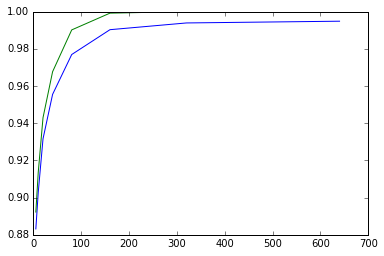

In [18]:
model_params = dict([('target', 'type'), ('features', features), ('verbose', False), ('validation_set', None)])
model_factory = graphlab.boosted_trees_classifier.create
type_max_iterations = get_best_max_iterations(not_noise_k_fold, max_iterations_a, model_factory, 
                                              model_params, f1_score)

At depth: 1 0.873857929626 0.87847534338
At depth: 2 0.955556173779 0.968480152289
At depth: 3 0.98466213893 0.996655639798
At depth: 4 0.992375341503 0.99998867304
At depth: 5 0.994537608483 1.0
At depth: 6 0.994835255181 1.0
At depth: 7 0.995019327795 1.0
At depth: 8 0.994922530385 1.0
At depth: 9 0.994946188038 1.0


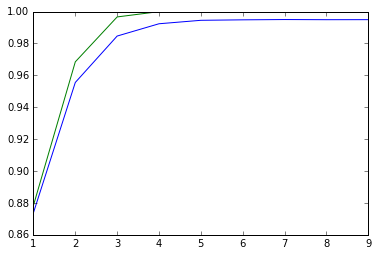

In [19]:
depths = range(1,10)

model_params['max_iterations'] = type_max_iterations[0]
type_max_depth = get_best_depth(not_noise_k_fold, depths, model_factory, model_params, f1_score)

In [20]:
train_set_to_use = not_noise_train
max_depth_to_use = type_max_depth[0]
max_iterations_to_use = type_max_iterations[0]

optimized_type_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='type', features=features,
                                                                     max_depth=max_depth_to_use, max_iterations=max_iterations_to_use)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 48449

Number of classes           : 2

Number of feature columns   : 38

Number of unpacked features : 38

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.138270     | 0.890091          | 0.875048            | 0.524575          | 0.531029            |

| 2         | 0.252405     | 0.905674          | 0.890474            | 0.422849          | 0.432342            |

| 3         | 0.377091     | 0.914921          | 0.900501            | 0.355779          | 0.366399            |

| 4         | 0.507624     | 0.917769          | 0.900501            | 0.310362          | 0.324362            |

| 5         | 0.637893     | 0.924044          | 0.909757            | 0.275358          | 0.292167            |

| 6         | 0.764858     | 0.929018          | 0.914771            | 0.248143          | 0.266210            |

| 10        | 1.204482     | 0.943487          | 0.929811            | 0.182819          | 0.204398            |

| 11        | 1.313279     | 0.944829          | 0.933282            | 0.174766          | 0.197444            |

| 20        | 2.231465     | 0.962806          | 0.953336            | 0.124302          | 0.147155            |

| 30        | 3.242757     | 0.977585          | 0.966062            | 0.084162          | 0.109052            |

| 40        | 4.183735     | 0.984664          | 0.974547            | 0.065348          | 0.091426            |

| 50        | 5.128504     | 0.990093          | 0.979946            | 0.050398          | 0.077223            |

| 51        | 5.243802     | 0.990526          | 0.978403            | 0.048695          | 0.075297            |

| 60        | 6.172737     | 0.994221          | 0.983803            | 0.036561          | 0.059026            |

| 70        | 7.147254     | 0.996409          | 0.986888            | 0.028950          | 0.048982            |

| 80        | 8.209975     | 0.997626          | 0.987659            | 0.022807          | 0.040952            |

| 90        | 9.405752     | 0.998452          | 0.988045            | 0.018086          | 0.035727            |

| 100       | 10.352684    | 0.998803          | 0.989202            | 0.015011          | 0.031395            |

| 101       | 10.483515    | 0.998844          | 0.989587            | 0.014769          | 0.031117            |

| 110       | 11.506113    | 0.999360          | 0.991901            | 0.011858          | 0.027733            |

| 120       | 12.808074    | 0.999505          | 0.993444            | 0.009786          | 0.025016            |

| 130       | 13.902174    | 0.999711          | 0.993830            | 0.007623          | 0.022257            |

| 140       | 15.196324    | 0.999794          | 0.994601            | 0.006212          | 0.019593            |

| 150       | 16.297274    | 0.999959          | 0.995758            | 0.004933          | 0.017123            |

| 160       | 17.307445    | 0.999959          | 0.996143            | 0.004071          | 0.016048            |

| 170       | 18.263366    | 1.000000          | 0.996143            | 0.003470          | 0.014800            |

| 180       | 19.225284    | 1.000000          | 0.996143            | 0.002960          | 0.013761            |

| 190       | 20.221458    | 1.000000          | 0.996529            | 0.002570          | 0.013349            |

| 200       | 21.204704    | 1.000000          | 0.996529            | 0.002147          | 0.012390            |

| 210       | 22.147099    | 1.000000          | 0.996143            | 0.001914          | 0.011974            |

| 220       | 23.106037    | 1.000000          | 0.996529            | 0.001666          | 0.011500            |

| 230       | 24.052559    | 1.000000          | 0.996529            | 0.001455          | 0.010869            |

| 240       | 25.041969    | 1.000000          | 0.996529            | 0.001225          | 0.010581            |

| 250       | 25.982523    | 1.000000          | 0.996143            | 0.001110          | 0.010403            |

| 260       | 26.959774    | 1.000000          | 0.996529            | 0.001002          | 0.010000            |

| 270       | 27.918558    | 1.000000          | 0.996529            | 0.000910          | 0.009672            |

| 280       | 28.832093    | 1.000000          | 0.996143            | 0.000827          | 0.009421            |

| 290       | 29.768675    | 1.000000          | 0.996529            | 0.000769          | 0.009398            |

| 300       | 30.765029    | 1.000000          | 0.996529            | 0.000694          | 0.009150            |

| 310       | 31.713440    | 1.000000          | 0.996529            | 0.000640          | 0.008956            |

| 320       | 32.721323    | 1.000000          | 0.996529            | 0.000592          | 0.009031            |

| 330       | 33.663358    | 1.000000          | 0.996529            | 0.000553          | 0.008906            |

| 340       | 34.641621    | 1.000000          | 0.996529            | 0.000505          | 0.008590            |

| 350       | 35.582467    | 1.000000          | 0.996915            | 0.000474          | 0.008498            |

| 360       | 36.536921    | 1.000000          | 0.996529            | 0.000447          | 0.008461            |

| 370       | 37.527227    | 1.000000          | 0.996143            | 0.000420          | 0.008428            |

| 380       | 38.477279    | 1.000000          | 0.996529            | 0.000395          | 0.008251            |

| 390       | 39.447528    | 1.000000          | 0.996529            | 0.000373          | 0.008305            |

| 400       | 40.388058    | 1.000000          | 0.996529            | 0.000351          | 0.008236            |

| 410       | 41.338668    | 1.000000          | 0.996529            | 0.000335          | 0.008146            |

| 420       | 42.233799    | 1.000000          | 0.996529            | 0.000320          | 0.008090            |

| 430       | 43.161264    | 1.000000          | 0.996529            | 0.000307          | 0.007951            |

| 440       | 44.052425    | 1.000000          | 0.996529            | 0.000294          | 0.007781            |

| 450       | 44.963065    | 1.000000          | 0.996529            | 0.000280          | 0.007668            |

| 460       | 45.919118    | 1.000000          | 0.996529            | 0.000269          | 0.007550            |

| 470       | 46.852814    | 1.000000          | 0.996529            | 0.000258          | 0.007597            |

| 480       | 47.815037    | 1.000000          | 0.996529            | 0.000247          | 0.007569            |

| 490       | 48.778723    | 1.000000          | 0.996529            | 0.000238          | 0.007516            |

| 500       | 49.748239    | 1.000000          | 0.996529            | 0.000229          | 0.007495            |

| 501       | 49.883563    | 1.000000          | 0.996529            | 0.000228          | 0.007481            |

| 510       | 50.766928    | 1.000000          | 0.996529            | 0.000222          | 0.007507            |

| 520       | 51.857037    | 1.000000          | 0.996529            | 0.000213          | 0.007388            |

| 530       | 52.814459    | 1.000000          | 0.996529            | 0.000206          | 0.007359            |

| 540       | 54.188510    | 1.000000          | 0.996529            | 0.000199          | 0.007385            |

| 550       | 55.253108    | 1.000000          | 0.996529            | 0.000193          | 0.007365            |

| 560       | 56.235248    | 1.000000          | 0.996529            | 0.000187          | 0.007322            |

| 570       | 57.331307    | 1.000000          | 0.996529            | 0.000181          | 0.007314            |

| 580       | 58.323843    | 1.000000          | 0.996529            | 0.000175          | 0.007302            |

| 590       | 59.248039    | 1.000000          | 0.996529            | 0.000171          | 0.007221            |

| 600       | 60.135403    | 1.000000          | 0.996529            | 0.000166          | 0.007163            |

| 610       | 61.083712    | 1.000000          | 0.996529            | 0.000162          | 0.007150            |

| 620       | 62.058438    | 1.000000          | 0.996529            | 0.000157          | 0.007137            |

| 630       | 62.972501    | 1.000000          | 0.996529            | 0.000153          | 0.007055            |

| 640       | 63.966311    | 1.000000          | 0.996529            | 0.000150          | 0.007078            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [21]:
print optimized_type_classifier.evaluate(predicted_not_noise)

predicted_touches = predicted_not_noise[optimized_type_classifier.predict(predicted_not_noise) == "TOUCH"]
predicted_swipes = predicted_not_noise[optimized_type_classifier.predict(predicted_not_noise) == "SWIPE"]

{'f1_score': 0.6575859121700228, 'auc': 0.9999220424081543, 'recall': 0.6647326844812899, 'precision': 0.9759281147599769, 'log_loss': 0.705439727564253, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+-----+------+------+
| threshold |      fpr       | tpr |  p   |  n   |
+-----------+----------------+-----+------+------+
|    0.0    |      1.0       | 1.0 | 5441 | 7055 |
|   1e-05   | 0.463217576187 | 1.0 | 5441 | 7055 |
|   2e-05   | 0.390928419561 | 1.0 | 5441 | 7055 |
|   3e-05   | 0.350389794472 | 1.0 | 5441 | 7055 |
|   4e-05   | 0.32402551382  | 1.0 | 5441 | 7055 |
|   5e-05   | 0.302905740609 | 1.0 | 5441 | 7055 |
|   6e-05   | 0.285187810064 | 1.0 | 5441 | 7055 |
|   7e-05   | 0.271013465627 | 1.0 | 5441 | 7055 |
|   8e-05   | 0.259815733522 | 1.0 | 5441 | 7055 |
|   9e-05   | 0.250177179305 | 1.0 | 5441 | 7055 |
+-----------+----------------+-----+------+------+
[100001 rows x 5 columns]
Note: Only

# Let's classify swipes

In [22]:
swipes_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train_swipes), 5)

At iterations: 5 0.796206933056 0.816023928165
At iterations: 10 0.842020493487 0.867053219683
At iterations: 20 0.89526407564 0.921592437446
At iterations: 40 0.953997416389 0.977312222377
At iterations: 80 0.987424125923 0.998052151554
At iterations: 160 0.994326181779 1.0
At iterations: 320 0.99549175912 1.0
At iterations: 640 0.995649590689 1.0


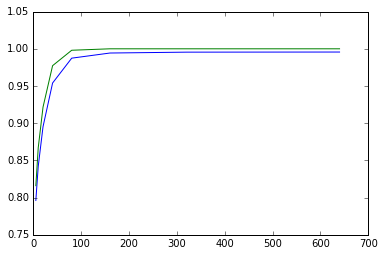

In [23]:
model_params = dict([('target', 'action'), ('features', features), ('verbose', False), ('validation_set', None)])
model_factory = graphlab.boosted_trees_classifier.create
swipe_max_iterations = get_best_max_iterations(swipes_k_fold, max_iterations_a, model_factory, model_params, f1_score)

At depth: 1 0.730980264233 0.748394079981
At depth: 2 0.937231479897 0.967214042018
At depth: 3 0.989918642382 0.999609538788
At depth: 4 0.993972200662 1.0
At depth: 5 0.995467867878 1.0
At depth: 6 0.995649590689 1.0
At depth: 7 0.996055956876 1.0
At depth: 8 0.996053975038 1.0
At depth: 9 0.995855372045 1.0


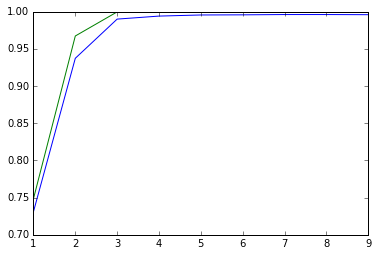

In [36]:
depths = range(1,10)

model_params['max_iterations'] = swipe_max_iterations[0]
swipe_max_depth = get_best_depth(swipes_k_fold, depths, model_factory, model_params, f1_score)

In [37]:
train_set_to_use = train_swipes
max_depth_to_use = swipe_max_depth[0]
max_iterations_to_use = swipe_max_iterations[0]

optimized_swipe_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='action', features=features,
                                                                     max_depth=max_depth_to_use, max_iterations=max_iterations_to_use)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 27470

Number of classes           : 4

Number of feature columns   : 38

Number of unpacked features : 38

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.254105     | 0.793484          | 0.787126            | 1.104222          | 1.109612            |

| 2         | 0.506927     | 0.827958          | 0.810707            | 0.923000          | 0.935042            |

| 3         | 0.765424     | 0.844703          | 0.831103            | 0.798508          | 0.813695            |

| 4         | 0.999845     | 0.852494          | 0.843212            | 0.705738          | 0.723782            |

| 5         | 1.246650     | 0.867674          | 0.855959            | 0.631908          | 0.656283            |

| 6         | 1.503285     | 0.877430          | 0.863607            | 0.571685          | 0.599409            |

| 10        | 2.500156     | 0.914088          | 0.891013            | 0.396833          | 0.434357            |

| 11        | 2.755302     | 0.920750          | 0.895475            | 0.368820          | 0.407255            |

| 15        | 3.681746     | 0.940335          | 0.915233            | 0.291082          | 0.329655            |

| 20        | 4.818097     | 0.960794          | 0.933078            | 0.226551          | 0.266051            |

| 25        | 5.917832     | 0.975137          | 0.954111            | 0.176522          | 0.215983            |

| 30        | 7.043824     | 0.984310          | 0.966858            | 0.138474          | 0.174409            |

| 35        | 8.177394     | 0.990681          | 0.980880            | 0.107785          | 0.138309            |

| 40        | 9.292382     | 0.993302          | 0.984704            | 0.088413          | 0.116904            |

| 45        | 10.451754    | 0.996542          | 0.989802            | 0.065876          | 0.094605            |

| 50        | 11.551373    | 0.997233          | 0.991077            | 0.056117          | 0.083435            |

| 51        | 11.780748    | 0.997379          | 0.990440            | 0.053439          | 0.080770            |

| 55        | 12.681458    | 0.998034          | 0.991077            | 0.046596          | 0.073275            |

| 60        | 13.828475    | 0.998944          | 0.992989            | 0.036501          | 0.060430            |

| 65        | 14.960412    | 0.999636          | 0.993627            | 0.029515          | 0.051435            |

| 70        | 16.099257    | 0.999745          | 0.994264            | 0.023544          | 0.043548            |

| 75        | 17.292947    | 0.999818          | 0.995539            | 0.019664          | 0.038490            |

| 80        | 18.464912    | 0.999854          | 0.996176            | 0.016206          | 0.034084            |

| 85        | 19.613754    | 0.999964          | 0.996813            | 0.013317          | 0.030255            |

| 90        | 20.813219    | 1.000000          | 0.996813            | 0.011285          | 0.027331            |

| 95        | 21.925899    | 1.000000          | 0.996813            | 0.009346          | 0.024441            |

| 100       | 23.087664    | 1.000000          | 0.997451            | 0.007600          | 0.021456            |

| 101       | 23.330472    | 1.000000          | 0.996813            | 0.007354          | 0.021119            |

| 105       | 24.225071    | 1.000000          | 0.996813            | 0.006465          | 0.019887            |

| 110       | 25.391247    | 1.000000          | 0.996813            | 0.005427          | 0.018191            |

| 115       | 26.512640    | 1.000000          | 0.997451            | 0.004726          | 0.017143            |

| 120       | 27.704082    | 1.000000          | 0.997451            | 0.003943          | 0.016167            |

| 125       | 28.827806    | 1.000000          | 0.997451            | 0.003455          | 0.015178            |

| 130       | 29.978766    | 1.000000          | 0.997451            | 0.002972          | 0.014388            |

| 135       | 31.057745    | 1.000000          | 0.997451            | 0.002702          | 0.013890            |

| 140       | 32.179417    | 1.000000          | 0.997451            | 0.002411          | 0.013422            |

| 145       | 33.282481    | 1.000000          | 0.997451            | 0.002182          | 0.012881            |

| 150       | 34.379453    | 1.000000          | 0.997451            | 0.001962          | 0.012479            |

| 155       | 35.513389    | 1.000000          | 0.997451            | 0.001743          | 0.012084            |

| 160       | 36.600302    | 1.000000          | 0.997451            | 0.001581          | 0.011806            |

| 165       | 37.676133    | 1.000000          | 0.997451            | 0.001468          | 0.011648            |

| 170       | 38.759539    | 1.000000          | 0.997451            | 0.001359          | 0.011338            |

| 175       | 39.852582    | 1.000000          | 0.997451            | 0.001237          | 0.010971            |

| 180       | 40.970188    | 1.000000          | 0.997451            | 0.001133          | 0.010798            |

| 185       | 42.191750    | 1.000000          | 0.997451            | 0.001051          | 0.010578            |

| 190       | 43.244521    | 1.000000          | 0.997451            | 0.000978          | 0.010437            |

| 195       | 44.359554    | 1.000000          | 0.997451            | 0.000913          | 0.010318            |

| 200       | 45.460044    | 1.000000          | 0.997451            | 0.000854          | 0.010030            |

| 205       | 46.557997    | 1.000000          | 0.997451            | 0.000790          | 0.009716            |

| 210       | 47.640091    | 1.000000          | 0.997451            | 0.000735          | 0.009546            |

| 215       | 48.670466    | 1.000000          | 0.997451            | 0.000701          | 0.009565            |

| 220       | 49.761063    | 1.000000          | 0.997451            | 0.000658          | 0.009461            |

| 225       | 50.853500    | 1.000000          | 0.997451            | 0.000620          | 0.009258            |

| 230       | 51.922860    | 1.000000          | 0.998088            | 0.000588          | 0.009222            |

| 235       | 52.941652    | 1.000000          | 0.998088            | 0.000559          | 0.009189            |

| 240       | 53.987515    | 1.000000          | 0.998088            | 0.000534          | 0.009143            |

| 245       | 55.072057    | 1.000000          | 0.998088            | 0.000511          | 0.009015            |

| 250       | 56.120272    | 1.000000          | 0.998088            | 0.000489          | 0.008882            |

| 255       | 57.175612    | 1.000000          | 0.998088            | 0.000468          | 0.008880            |

| 260       | 58.240286    | 1.000000          | 0.998088            | 0.000448          | 0.008766            |

| 265       | 59.289267    | 1.000000          | 0.998088            | 0.000430          | 0.008754            |

| 270       | 60.426482    | 1.000000          | 0.998088            | 0.000414          | 0.008678            |

| 275       | 61.447562    | 1.000000          | 0.998088            | 0.000400          | 0.008630            |

| 280       | 62.456693    | 1.000000          | 0.998088            | 0.000386          | 0.008612            |

| 285       | 63.489059    | 1.000000          | 0.998088            | 0.000373          | 0.008557            |

| 290       | 64.521431    | 1.000000          | 0.998088            | 0.000359          | 0.008599            |

| 295       | 65.543988    | 1.000000          | 0.998088            | 0.000347          | 0.008620            |

| 300       | 66.591227    | 1.000000          | 0.998088            | 0.000335          | 0.008625            |

| 305       | 67.642739    | 1.000000          | 0.998088            | 0.000324          | 0.008591            |

| 310       | 68.660570    | 1.000000          | 0.998088            | 0.000315          | 0.008617            |

| 315       | 69.686666    | 1.000000          | 0.998088            | 0.000306          | 0.008632            |

| 320       | 70.724571    | 1.000000          | 0.998088            | 0.000298          | 0.008664            |

| 325       | 71.754482    | 1.000000          | 0.998088            | 0.000290          | 0.008658            |

| 330       | 72.779981    | 1.000000          | 0.998088            | 0.000282          | 0.008636            |

| 335       | 73.787626    | 1.000000          | 0.998088            | 0.000275          | 0.008631            |

| 340       | 74.842099    | 1.000000          | 0.998088            | 0.000268          | 0.008648            |

| 345       | 75.849594    | 1.000000          | 0.998088            | 0.000262          | 0.008687            |

| 350       | 76.876470    | 1.000000          | 0.998088            | 0.000256          | 0.008650            |

| 355       | 77.889235    | 1.000000          | 0.998088            | 0.000250          | 0.008685            |

| 360       | 78.902453    | 1.000000          | 0.998088            | 0.000245          | 0.008681            |

| 365       | 79.907122    | 1.000000          | 0.998088            | 0.000239          | 0.008680            |

| 370       | 80.928864    | 1.000000          | 0.998088            | 0.000234          | 0.008646            |

| 375       | 81.946441    | 1.000000          | 0.998088            | 0.000229          | 0.008619            |

| 380       | 82.949962    | 1.000000          | 0.998088            | 0.000224          | 0.008627            |

| 385       | 83.939593    | 1.000000          | 0.998088            | 0.000220          | 0.008660            |

| 390       | 84.929754    | 1.000000          | 0.998088            | 0.000216          | 0.008661            |

| 395       | 85.928555    | 1.000000          | 0.998088            | 0.000212          | 0.008653            |

| 400       | 86.932919    | 1.000000          | 0.998088            | 0.000208          | 0.008624            |

| 405       | 87.912837    | 1.000000          | 0.998088            | 0.000205          | 0.008664            |

| 410       | 88.879083    | 1.000000          | 0.998088            | 0.000201          | 0.008653            |

| 415       | 89.853917    | 1.000000          | 0.998088            | 0.000198          | 0.008640            |

| 420       | 90.820629    | 1.000000          | 0.998088            | 0.000195          | 0.008668            |

| 425       | 91.814415    | 1.000000          | 0.998088            | 0.000191          | 0.008632            |

| 430       | 92.779284    | 1.000000          | 0.998088            | 0.000188          | 0.008629            |

| 435       | 93.725165    | 1.000000          | 0.998088            | 0.000185          | 0.008613            |

| 440       | 94.699637    | 1.000000          | 0.998088            | 0.000182          | 0.008593            |

| 445       | 95.643592    | 1.000000          | 0.998088            | 0.000179          | 0.008609            |

| 450       | 96.601506    | 1.000000          | 0.998088            | 0.000177          | 0.008614            |

| 455       | 97.552860    | 1.000000          | 0.998088            | 0.000174          | 0.008605            |

| 460       | 98.526362    | 1.000000          | 0.998088            | 0.000171          | 0.008581            |

| 465       | 99.491730    | 1.000000          | 0.998088            | 0.000169          | 0.008569            |

| 470       | 100.447968   | 1.000000          | 0.998088            | 0.000167          | 0.008526            |

| 475       | 101.409236   | 1.000000          | 0.998088            | 0.000164          | 0.008528            |

| 480       | 102.350876   | 1.000000          | 0.998088            | 0.000162          | 0.008543            |

| 485       | 103.330226   | 1.000000          | 0.998088            | 0.000160          | 0.008541            |

| 490       | 104.280543   | 1.000000          | 0.998088            | 0.000158          | 0.008535            |

| 495       | 105.209319   | 1.000000          | 0.998088            | 0.000156          | 0.008507            |

| 500       | 106.157081   | 1.000000          | 0.998088            | 0.000154          | 0.008552            |

| 501       | 106.344987   | 1.000000          | 0.998088            | 0.000154          | 0.008550            |

| 505       | 107.103680   | 1.000000          | 0.998088            | 0.000152          | 0.008550            |

| 510       | 108.037048   | 1.000000          | 0.998088            | 0.000150          | 0.008550            |

| 515       | 108.983261   | 1.000000          | 0.998088            | 0.000149          | 0.008578            |

| 520       | 109.916845   | 1.000000          | 0.998088            | 0.000147          | 0.008571            |

| 525       | 110.862307   | 1.000000          | 0.998088            | 0.000145          | 0.008569            |

| 530       | 111.806130   | 1.000000          | 0.998088            | 0.000143          | 0.008576            |

| 535       | 112.758420   | 1.000000          | 0.998088            | 0.000142          | 0.008568            |

| 540       | 113.669820   | 1.000000          | 0.998088            | 0.000140          | 0.008587            |

| 545       | 114.590353   | 1.000000          | 0.998088            | 0.000139          | 0.008577            |

| 550       | 115.538449   | 1.000000          | 0.998088            | 0.000137          | 0.008607            |

| 555       | 116.485619   | 1.000000          | 0.998088            | 0.000136          | 0.008600            |

| 560       | 117.417566   | 1.000000          | 0.998088            | 0.000134          | 0.008574            |

| 565       | 118.365226   | 1.000000          | 0.998088            | 0.000133          | 0.008542            |

| 570       | 119.302100   | 1.000000          | 0.998088            | 0.000132          | 0.008521            |

| 575       | 120.243978   | 1.000000          | 0.998088            | 0.000130          | 0.008521            |

| 580       | 121.188110   | 1.000000          | 0.998088            | 0.000129          | 0.008493            |

| 585       | 122.097987   | 1.000000          | 0.998088            | 0.000128          | 0.008459            |

| 590       | 123.011462   | 1.000000          | 0.998088            | 0.000126          | 0.008455            |

| 595       | 123.939652   | 1.000000          | 0.998088            | 0.000125          | 0.008445            |

| 600       | 124.861610   | 1.000000          | 0.998088            | 0.000124          | 0.008443            |

| 605       | 125.767408   | 1.000000          | 0.998088            | 0.000123          | 0.008412            |

| 610       | 126.673211   | 1.000000          | 0.998088            | 0.000122          | 0.008432            |

| 615       | 127.572486   | 1.000000          | 0.998088            | 0.000121          | 0.008436            |

| 620       | 128.494755   | 1.000000          | 0.998088            | 0.000120          | 0.008433            |

| 625       | 129.424099   | 1.000000          | 0.998088            | 0.000119          | 0.008437            |

| 630       | 130.328154   | 1.000000          | 0.998088            | 0.000118          | 0.008439            |

| 635       | 131.258582   | 1.000000          | 0.998088            | 0.000117          | 0.008432            |

| 640       | 132.173588   | 1.000000          | 0.998088            | 0.000116          | 0.008446            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [38]:
print optimized_swipe_classifier.evaluate(predicted_swipes)

{'f1_score': 0.36029406910252554, 'auc': 0.9999693582538386, 'recall': 0.36302875412099794, 'precision': 0.9834070593330257, 'log_loss': 0.4990879684564093, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 400004

Data:
+-----------+----------------+-----+------+------+-------+
| threshold |      fpr       | tpr |  p   |  n   | class |
+-----------+----------------+-----+------+------+-------+
|    0.0    |      1.0       | 1.0 | 2298 | 4742 |   0   |
|   1e-05   | 0.430830873049 | 1.0 | 2298 | 4742 |   0   |
|   2e-05   | 0.347743568115 | 1.0 | 2298 | 4742 |   0   |
|   3e-05   | 0.300295234078 | 1.0 | 2298 | 4742 |   0   |
|   4e-05   | 0.266554196542 | 1.0 | 2298 | 4742 |   0   |
|   5e-05   | 0.238717840574 | 1.0 | 2298 | 4742 |   0   |
|   6e-05   | 0.217840573598 | 1.0 | 2298 | 4742 |   0   |
|   7e-05   | 0.200970054829 | 1.0 | 2298 | 4742 |   0   |
|   8e-05   | 0.189793336145 | 1.0 | 2298 | 4742 |   0   |
|   9e-05   | 0.177773091523

# Let's go with touch classifier

In [39]:
touches_k_fold = graphlab.cross_validation.KFold(graphlab.cross_validation.shuffle(train_touchs), 5)

At iterations: 5 0.750339582861 0.808801465455
At iterations: 10 0.804111420863 0.867776981311
At iterations: 20 0.870414390227 0.935385201467
At iterations: 40 0.937606779474 0.985125053867
At iterations: 80 0.97201327253 0.999288575588
At iterations: 160 0.981581114657 1.0
At iterations: 320 0.984294091364 1.0
At iterations: 640 0.985244150244 1.0


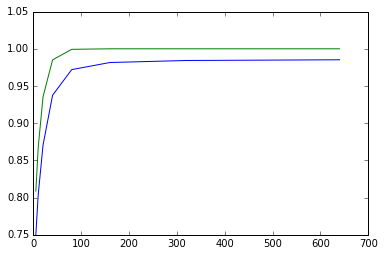

In [40]:
model_params = dict([('target', 'action'), ('features', features), ('verbose', False), ('validation_set', None)])
model_factory = graphlab.boosted_trees_classifier.create
touch_max_iterations = get_best_max_iterations(touches_k_fold, max_iterations_a, model_factory, model_params, f1_score)

At depth: 1 0.730980264233 0.748394079981
At depth: 2 0.937231479897 0.967214042018
At depth: 3 0.989918642382 0.999609538788
At depth: 4 0.993972200662 1.0
At depth: 5 0.995467867878 1.0
At depth: 6 0.995649590689 1.0
At depth: 7 0.996055956876 1.0
At depth: 8 0.996053975038 1.0
At depth: 9 0.995855372045 1.0


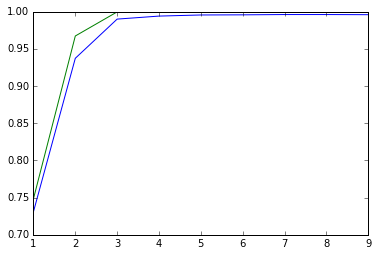

In [41]:
depths = range(1,10)

model_params['max_iterations'] = touch_max_iterations[0]
touch_max_depth = get_best_depth(swipes_k_fold, depths, model_factory, model_params, f1_score)

In [42]:
train_set_to_use = train_touchs
max_depth_to_use = touch_max_depth[0]
max_iterations_to_use = touch_max_iterations[0]

optimized_touch_classifier = graphlab.boosted_trees_classifier.create(train_set_to_use, target='action', features=features,
                                                                     max_depth=max_depth_to_use, max_iterations=max_iterations_to_use)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 20941

Number of classes           : 9

Number of feature columns   : 38

Number of unpacked features : 38

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Validation-accuracy | Training-log_loss | Validation-log_loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.470356     | 0.729669          | 0.702448            | 1.609792          | 1.623035            |

| 2         | 0.903469     | 0.787116          | 0.751412            | 1.322348          | 1.360626            |

| 3         | 1.361314     | 0.825080          | 0.789077            | 1.114383          | 1.166531            |

| 4         | 1.792097     | 0.850294          | 0.814501            | 0.965517          | 1.033541            |

| 5         | 2.226280     | 0.869777          | 0.830508            | 0.848530          | 0.920708            |

| 6         | 2.658636     | 0.883052          | 0.844633            | 0.756154          | 0.833928            |

| 10        | 4.328517     | 0.922783          | 0.868173            | 0.515659          | 0.617939            |

| 11        | 4.752845     | 0.930615          | 0.874765            | 0.475916          | 0.582129            |

| 15        | 6.415800     | 0.952772          | 0.894539            | 0.356648          | 0.472664            |

| 20        | 8.465934     | 0.972637          | 0.919021            | 0.264704          | 0.381711            |

| 25        | 10.483383    | 0.983000          | 0.933145            | 0.199740          | 0.312489            |

| 30        | 12.467745    | 0.989256          | 0.944444            | 0.159582          | 0.265909            |

| 35        | 14.506427    | 0.993315          | 0.949153            | 0.126087          | 0.226920            |

| 40        | 16.514864    | 0.996036          | 0.955744            | 0.098550          | 0.193946            |

| 45        | 18.513838    | 0.997374          | 0.963277            | 0.078782          | 0.168070            |

| 50        | 20.549639    | 0.998138          | 0.969868            | 0.061454          | 0.145845            |

| 51        | 20.970296    | 0.998185          | 0.970810            | 0.057878          | 0.141733            |

| 55        | 22.664964    | 0.998758          | 0.972693            | 0.048613          | 0.129276            |

| 60        | 24.851026    | 0.999522          | 0.973635            | 0.038006          | 0.115850            |

| 65        | 26.902483    | 0.999761          | 0.975518            | 0.030321          | 0.105252            |

| 70        | 29.032095    | 0.999857          | 0.974576            | 0.024784          | 0.097966            |

| 75        | 31.010322    | 0.999952          | 0.976460            | 0.019931          | 0.090696            |

| 80        | 32.964422    | 1.000000          | 0.976460            | 0.016453          | 0.084304            |

| 85        | 35.045096    | 1.000000          | 0.977401            | 0.013592          | 0.079702            |

| 90        | 37.116063    | 1.000000          | 0.979284            | 0.011344          | 0.075539            |

| 95        | 39.107169    | 1.000000          | 0.979284            | 0.009555          | 0.072281            |

| 100       | 41.093372    | 1.000000          | 0.979284            | 0.008102          | 0.069863            |

| 101       | 41.512361    | 1.000000          | 0.979284            | 0.007775          | 0.069077            |

| 105       | 43.133871    | 1.000000          | 0.979284            | 0.006883          | 0.067270            |

| 110       | 45.149997    | 1.000000          | 0.979284            | 0.005911          | 0.065343            |

| 115       | 47.068845    | 1.000000          | 0.979284            | 0.005124          | 0.062871            |

| 120       | 49.007439    | 1.000000          | 0.979284            | 0.004504          | 0.061747            |

| 125       | 50.904450    | 1.000000          | 0.979284            | 0.003975          | 0.060669            |

| 130       | 52.861586    | 1.000000          | 0.979284            | 0.003509          | 0.059429            |

| 135       | 54.767080    | 1.000000          | 0.980226            | 0.003141          | 0.058149            |

| 140       | 56.822247    | 1.000000          | 0.980226            | 0.002820          | 0.057944            |

| 145       | 58.696061    | 1.000000          | 0.980226            | 0.002561          | 0.057286            |

| 150       | 60.595541    | 1.000000          | 0.980226            | 0.002356          | 0.057302            |

| 155       | 62.476562    | 1.000000          | 0.981168            | 0.002162          | 0.056759            |

| 160       | 64.374958    | 1.000000          | 0.981168            | 0.001987          | 0.056056            |

| 165       | 66.308008    | 1.000000          | 0.981168            | 0.001846          | 0.055644            |

| 170       | 68.149964    | 1.000000          | 0.981168            | 0.001717          | 0.055192            |

| 175       | 69.989172    | 1.000000          | 0.981168            | 0.001604          | 0.054813            |

| 180       | 71.824976    | 1.000000          | 0.982109            | 0.001493          | 0.054429            |

| 185       | 73.635012    | 1.000000          | 0.982109            | 0.001400          | 0.054082            |

| 190       | 75.454876    | 1.000000          | 0.982109            | 0.001316          | 0.054308            |

| 195       | 77.396175    | 1.000000          | 0.982109            | 0.001246          | 0.054096            |

| 200       | 79.239003    | 1.000000          | 0.982109            | 0.001180          | 0.053553            |

| 205       | 81.045456    | 1.000000          | 0.982109            | 0.001120          | 0.053305            |

| 210       | 82.833497    | 1.000000          | 0.982109            | 0.001064          | 0.053010            |

| 215       | 84.633077    | 1.000000          | 0.982109            | 0.001016          | 0.052736            |

| 220       | 86.435017    | 1.000000          | 0.982109            | 0.000971          | 0.052801            |

| 225       | 88.269818    | 1.000000          | 0.982109            | 0.000929          | 0.052774            |

| 230       | 89.994105    | 1.000000          | 0.982109            | 0.000890          | 0.052396            |

| 235       | 91.740220    | 1.000000          | 0.982109            | 0.000855          | 0.052339            |

| 240       | 93.493611    | 1.000000          | 0.982109            | 0.000823          | 0.052276            |

| 245       | 95.241916    | 1.000000          | 0.982109            | 0.000791          | 0.052243            |

| 250       | 97.013963    | 1.000000          | 0.982109            | 0.000762          | 0.051973            |

| 255       | 99.224531    | 1.000000          | 0.982109            | 0.000736          | 0.051850            |

| 260       | 102.267273   | 1.000000          | 0.982109            | 0.000712          | 0.051524            |

| 265       | 104.519931   | 1.000000          | 0.982109            | 0.000692          | 0.051550            |

| 270       | 106.254535   | 1.000000          | 0.983051            | 0.000670          | 0.051415            |

| 275       | 107.978457   | 1.000000          | 0.983051            | 0.000651          | 0.051176            |

| 280       | 109.650721   | 1.000000          | 0.983051            | 0.000632          | 0.051068            |

| 285       | 111.345634   | 1.000000          | 0.983051            | 0.000615          | 0.050932            |

| 290       | 113.004098   | 1.000000          | 0.982109            | 0.000598          | 0.050755            |

| 295       | 114.675833   | 1.000000          | 0.982109            | 0.000583          | 0.050666            |

| 300       | 116.353749   | 1.000000          | 0.982109            | 0.000568          | 0.050495            |

| 305       | 117.992420   | 1.000000          | 0.982109            | 0.000555          | 0.050436            |

| 310       | 119.635684   | 1.000000          | 0.983051            | 0.000541          | 0.050437            |

| 315       | 121.270161   | 1.000000          | 0.983051            | 0.000528          | 0.050389            |

| 320       | 123.005703   | 1.000000          | 0.983051            | 0.000516          | 0.050281            |

| 325       | 124.623890   | 1.000000          | 0.983051            | 0.000505          | 0.050392            |

| 330       | 126.273408   | 1.000000          | 0.983051            | 0.000494          | 0.050426            |

| 335       | 127.886394   | 1.000000          | 0.983051            | 0.000485          | 0.050474            |

| 340       | 129.499884   | 1.000000          | 0.983051            | 0.000475          | 0.050421            |

| 345       | 131.084591   | 1.000000          | 0.983051            | 0.000465          | 0.050459            |

| 350       | 132.694332   | 1.000000          | 0.983051            | 0.000456          | 0.050578            |

| 355       | 134.280440   | 1.000000          | 0.983051            | 0.000447          | 0.050726            |

| 360       | 135.899641   | 1.000000          | 0.983051            | 0.000439          | 0.050725            |

| 365       | 137.520395   | 1.000000          | 0.983051            | 0.000431          | 0.050717            |

| 370       | 139.103254   | 1.000000          | 0.983992            | 0.000423          | 0.050733            |

| 375       | 140.663952   | 1.000000          | 0.983051            | 0.000416          | 0.050605            |

| 380       | 142.278572   | 1.000000          | 0.983992            | 0.000409          | 0.050420            |

| 385       | 143.902304   | 1.000000          | 0.983992            | 0.000403          | 0.050415            |

| 390       | 145.450964   | 1.000000          | 0.983992            | 0.000396          | 0.050422            |

| 395       | 147.046175   | 1.000000          | 0.983992            | 0.000389          | 0.050564            |

| 400       | 148.643263   | 1.000000          | 0.983992            | 0.000383          | 0.050365            |

| 405       | 150.199336   | 1.000000          | 0.983992            | 0.000378          | 0.050302            |

| 410       | 151.739987   | 1.000000          | 0.983992            | 0.000372          | 0.050303            |

| 415       | 153.314293   | 1.000000          | 0.983992            | 0.000366          | 0.050353            |

| 420       | 154.851786   | 1.000000          | 0.983992            | 0.000361          | 0.050236            |

| 425       | 156.393504   | 1.000000          | 0.983992            | 0.000356          | 0.050375            |

| 430       | 157.898646   | 1.000000          | 0.983992            | 0.000351          | 0.050373            |

| 435       | 159.408739   | 1.000000          | 0.983992            | 0.000346          | 0.050326            |

| 440       | 160.954314   | 1.000000          | 0.983992            | 0.000342          | 0.050324            |

| 445       | 162.459787   | 1.000000          | 0.983992            | 0.000337          | 0.050412            |

| 450       | 163.984214   | 1.000000          | 0.983992            | 0.000333          | 0.050379            |

| 455       | 165.502088   | 1.000000          | 0.983992            | 0.000328          | 0.050427            |

| 460       | 167.094624   | 1.000000          | 0.983992            | 0.000324          | 0.050415            |

| 465       | 168.631699   | 1.000000          | 0.983992            | 0.000320          | 0.050470            |

| 470       | 170.153007   | 1.000000          | 0.983992            | 0.000316          | 0.050524            |

| 475       | 171.737806   | 1.000000          | 0.983992            | 0.000312          | 0.050550            |

| 480       | 173.246894   | 1.000000          | 0.983992            | 0.000309          | 0.050531            |

| 485       | 174.782793   | 1.000000          | 0.983992            | 0.000305          | 0.050557            |

| 490       | 176.284587   | 1.000000          | 0.983992            | 0.000302          | 0.050552            |

| 495       | 177.741619   | 1.000000          | 0.983992            | 0.000298          | 0.050621            |

| 500       | 179.211342   | 1.000000          | 0.983992            | 0.000295          | 0.050659            |

| 501       | 179.514799   | 1.000000          | 0.983992            | 0.000294          | 0.050623            |

| 505       | 180.679973   | 1.000000          | 0.983992            | 0.000292          | 0.050624            |

| 510       | 182.126636   | 1.000000          | 0.983992            | 0.000289          | 0.050728            |

| 515       | 183.568934   | 1.000000          | 0.983992            | 0.000286          | 0.050669            |

| 520       | 185.049577   | 1.000000          | 0.983992            | 0.000283          | 0.050723            |

| 525       | 186.512556   | 1.000000          | 0.983992            | 0.000280          | 0.050809            |

| 530       | 187.977255   | 1.000000          | 0.983992            | 0.000277          | 0.050916            |

| 535       | 189.455442   | 1.000000          | 0.983992            | 0.000275          | 0.050932            |

| 540       | 190.895848   | 1.000000          | 0.983992            | 0.000272          | 0.050961            |

| 545       | 192.320188   | 1.000000          | 0.983992            | 0.000269          | 0.051009            |

| 550       | 193.762707   | 1.000000          | 0.983992            | 0.000267          | 0.050998            |

| 555       | 195.177398   | 1.000000          | 0.983992            | 0.000264          | 0.051005            |

| 560       | 196.770826   | 1.000000          | 0.983992            | 0.000262          | 0.051047            |

| 565       | 198.200830   | 1.000000          | 0.983992            | 0.000260          | 0.051106            |

| 570       | 199.640338   | 1.000000          | 0.983992            | 0.000257          | 0.051026            |

| 575       | 201.081129   | 1.000000          | 0.984934            | 0.000255          | 0.050988            |

| 580       | 202.527603   | 1.000000          | 0.983992            | 0.000253          | 0.050951            |

| 585       | 203.907905   | 1.000000          | 0.983992            | 0.000251          | 0.050972            |

| 590       | 205.322354   | 1.000000          | 0.984934            | 0.000249          | 0.050905            |

| 595       | 206.766309   | 1.000000          | 0.984934            | 0.000247          | 0.050830            |

| 600       | 208.245525   | 1.000000          | 0.984934            | 0.000245          | 0.050804            |

| 605       | 209.788720   | 1.000000          | 0.984934            | 0.000243          | 0.050682            |

| 610       | 211.211599   | 1.000000          | 0.985876            | 0.000241          | 0.050657            |

| 615       | 212.640858   | 1.000000          | 0.985876            | 0.000239          | 0.050645            |

| 620       | 214.102589   | 1.000000          | 0.985876            | 0.000237          | 0.050661            |

| 625       | 215.505913   | 1.000000          | 0.985876            | 0.000235          | 0.050662            |

| 630       | 216.888209   | 1.000000          | 0.985876            | 0.000233          | 0.050733            |

| 635       | 218.344740   | 1.000000          | 0.985876            | 0.000232          | 0.050635            |

| 640       | 219.720142   | 1.000000          | 0.985876            | 0.000230          | 0.050675            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

In [43]:
print optimized_touch_classifier.evaluate(predicted_touches)

{'f1_score': 0.6281535086686453, 'auc': 0.9998861901152273, 'recall': 0.6375780375157218, 'precision': 0.963047972611353, 'log_loss': 1.1940603894550694, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 900009

Data:
+-----------+----------------+-----+-----+------+-------+
| threshold |      fpr       | tpr |  p  |  n   | class |
+-----------+----------------+-----+-----+------+-------+
|    0.0    |      1.0       | 1.0 | 729 | 4692 |   0   |
|   1e-05   | 0.496803069054 | 1.0 | 729 | 4692 |   0   |
|   2e-05   | 0.416879795396 | 1.0 | 729 | 4692 |   0   |
|   3e-05   | 0.367647058824 | 1.0 | 729 | 4692 |   0   |
|   4e-05   | 0.333120204604 | 1.0 | 729 | 4692 |   0   |
|   5e-05   | 0.309889173061 | 1.0 | 729 | 4692 |   0   |
|   6e-05   | 0.288576300085 | 1.0 | 729 | 4692 |   0   |
|   7e-05   | 0.26747655584  | 1.0 | 729 | 4692 |   0   |
|   8e-05   | 0.250639386189 | 1.0 | 729 | 4692 |   0   |
|   9e-05   | 0.24104859335  | 1.0 | 729 | 

In [44]:
optimized_noise_classifier.save("noise_model")
optimized_type_classifier.save("type_model")
optimized_swipe_classifier.save("swipe_model")
optimized_touch_classifier.save("touch_model")